## 1. Import Libraries

In [40]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'pkill' is not recognized as an internal or external command,
operable program or batch file.


PyTorch version: 2.9.1+cu128
Device: cuda


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file models already exists.
Error occurred while processing: models.


In [41]:
base_path = Path.cwd().resolve()

datasets_path = base_path / "an2dl2526c2"
if not datasets_path.exists():
    fallback_path = base_path.parent / "an2dl2526c2"
    if fallback_path.exists():
        datasets_path = fallback_path
    else:
        raise FileNotFoundError(f"Dataset folder not found at {datasets_path} or {fallback_path}")

train_data_path = datasets_path / "train_data"
train_labels_path = datasets_path / "train_labels.csv"
test_data_path = datasets_path / "test_data"
output_path = datasets_path / "train_masked"

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Output path: {output_path}")

CSV_PATH = str(train_labels_path)
SOURCE_FOLDER = str(train_data_path)
OUTPUT_FOLDER = str(output_path)
TEST_IMAGE_PATH = str(test_data_path)
# if not Path(SOURCE_FOLDER).exists():
#     candidate_datasets = [
#         datasets_path,
#         base_path.parent / "an2dl2526c2",
#         Path(r"C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2"),
#     ]
#     for candidate in candidate_datasets:
#         if candidate.exists():
#             datasets_path = candidate
#             train_data_path = datasets_path / "train_data"
#             train_labels_path = datasets_path / "train_labels.csv"
#             test_data_path = datasets_path / "test_data"
#             output_path = datasets_path / "train_masked"

#             CSV_PATH = str(train_labels_path)
#             SOURCE_FOLDER = str(train_data_path)
#             OUTPUT_FOLDER = str(output_path)

#             print(f"Resolved dataset path: {datasets_path}")
#             break
#     else:
#         raise FileNotFoundError(
#             "Dataset folder not found in any of the candidate locations:\n"
#             + "\n".join(str(p) for p in candidate_datasets)
#         )

Dataset path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2
Train data path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_data
Train labels path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_labels.csv
Test data path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\test_data
Output path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_masked


### Filtering helper functions

In [42]:
def detect_shrek_image(image, yellow_olive_threshold=0.08):
    """
    Detects if an image contains yellow/olive/brown Shrek tissue (should be excluded entirely).
    
    Args:
        image: Input image in BGR format (0-255 range)
        yellow_olive_threshold: Minimum ratio of yellow-olive pixels to exclude (default 8%)
    
    Returns:
        is_shrek: Boolean indicating if this is a Shrek-contaminated image
        yellow_ratio: The ratio of yellow-olive pixels found
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Detect yellow-olive-brown tissue (the Shrek colored tissue)
    # Very broad range to catch all variants from bright yellow to dark brown
    # Hue: 5-75 (very broad yellow to yellow-green-brown range)
    # Saturation: 15-255 (very low to catch highly desaturated brown)
    # Value: 15-235 (very broad to catch extremely dark to bright variants)
    lower_yellow_olive = np.array([5, 15, 15])
    upper_yellow_olive = np.array([75, 255, 235])
    yellow_mask = cv2.inRange(hsv, lower_yellow_olive, upper_yellow_olive)
    
    # Apply morphological operations to get contiguous Shrek regions
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    yellow_mask = cv2.morphologyEx(yellow_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    yellow_mask = cv2.morphologyEx(yellow_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Calculate percentage of yellow-olive-brown pixels
    total_pixels = image.shape[0] * image.shape[1]
    yellow_pixels = np.count_nonzero(yellow_mask)
    yellow_ratio = yellow_pixels / total_pixels
    
    # If more than threshold% is yellow-olive-brown, it's a Shrek image
    is_shrek = yellow_ratio >= yellow_olive_threshold
    
    return is_shrek, yellow_ratio


def filter_green_goo(image):
    """ 
    Removes bright saturated green goo contamination from images using multi-pass intelligent inpainting.
    Enhanced to remove residual green artifacts.
    
    Args:
        image: Input image in BGR format (0-255 range)
        
    Returns:
        result_bgr: Filtered image with green goo removed
        green_mask: Mask of detected green areas
    """
    original_bgr = image.astype(np.uint8)
    result_bgr = original_bgr.copy()
    
    # Multi-pass approach to catch all green contamination
    for pass_num in range(2):  # Two passes to catch residual green
        hsv = cv2.cvtColor(result_bgr, cv2.COLOR_BGR2HSV)
        
        # Pass 1: Detect bright saturated green contamination
        lower_green_bright = np.array([35, 70, 40])  # Expanded range
        upper_green_bright = np.array([95, 255, 255])
        green_mask_bright = cv2.inRange(hsv, lower_green_bright, upper_green_bright)
        
        # Pass 2: Detect subtle/pale green tones (residual contamination)
        lower_green_pale = np.array([30, 30, 50])  # Lower saturation for pale green
        upper_green_pale = np.array([100, 120, 255])
        green_mask_pale = cv2.inRange(hsv, lower_green_pale, upper_green_pale)
        
        # Pass 3: Detect very bright pale green (like in your image)
        lower_green_very_pale = np.array([25, 20, 180])  # Very desaturated, bright
        upper_green_very_pale = np.array([110, 80, 255])
        green_mask_very_pale = cv2.inRange(hsv, lower_green_very_pale, upper_green_very_pale)
        
        # Combine all green masks
        combined_green_mask = cv2.bitwise_or(green_mask_bright, green_mask_pale)
        combined_green_mask = cv2.bitwise_or(combined_green_mask, green_mask_very_pale)
        
        # Morphological operations to clean and expand the mask
        kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
        
        # Clean up noise
        final_mask = cv2.morphologyEx(combined_green_mask, cv2.MORPH_OPEN, kernel_small, iterations=1)
        # Close gaps
        final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel_medium, iterations=2)
        # Dilate to capture edges and residuals
        final_mask = cv2.dilate(final_mask, kernel_large, iterations=3)
        
        # Check if there's any green to remove
        if np.count_nonzero(final_mask) == 0:
            break  # No more green detected, exit early
        
        # Apply inpainting with larger radius for better results
        result_bgr = cv2.inpaint(result_bgr, final_mask, inpaintRadius=10, flags=cv2.INPAINT_TELEA)
    
    return result_bgr, final_mask


Found 691 images to process


Processing images:   1%|          | 8/691 [00:00<00:37, 18.32it/s]

  Excluding Shrek image and mask: img_0005.png / mask_0005.png
  Excluding Shrek image and mask: img_0008.png / mask_0008.png


Processing images:   3%|▎         | 24/691 [00:02<01:04, 10.38it/s]

  Excluding Shrek image and mask: img_0022.png / mask_0022.png


Processing images:   4%|▍         | 31/691 [00:02<00:39, 16.56it/s]

  Excluding Shrek image and mask: img_0027.png / mask_0027.png
  Excluding Shrek image and mask: img_0028.png / mask_0028.png


Processing images:   6%|▌         | 40/691 [00:02<00:33, 19.28it/s]

  Excluding Shrek image and mask: img_0036.png / mask_0036.png


Processing images:   7%|▋         | 51/691 [00:03<00:44, 14.32it/s]

  Excluding Shrek image and mask: img_0047.png / mask_0047.png
  Excluding Shrek image and mask: img_0048.png / mask_0048.png


Processing images:  10%|▉         | 66/691 [00:04<00:37, 16.58it/s]

  Excluding Shrek image and mask: img_0062.png / mask_0062.png


Processing images:  13%|█▎        | 89/691 [00:06<00:34, 17.52it/s]

  Excluding Shrek image and mask: img_0085.png / mask_0085.png


Processing images:  14%|█▍        | 98/691 [00:07<00:49, 11.87it/s]

  Excluding Shrek image and mask: img_0095.png / mask_0095.png


Processing images:  18%|█▊        | 126/691 [00:08<00:25, 22.40it/s]

  Excluding Shrek image and mask: img_0126.png / mask_0126.png
  Excluding Shrek image and mask: img_0129.png / mask_0129.png


Processing images:  20%|█▉        | 138/691 [00:08<00:28, 19.53it/s]

  Excluding Shrek image and mask: img_0133.png / mask_0133.png
  Excluding Shrek image and mask: img_0136.png / mask_0136.png
  Excluding Shrek image and mask: img_0138.png / mask_0138.png


Processing images:  21%|██▏       | 148/691 [00:09<00:25, 20.97it/s]

  Excluding Shrek image and mask: img_0148.png / mask_0148.png


Processing images:  23%|██▎       | 161/691 [00:10<00:23, 22.32it/s]

  Excluding Shrek image and mask: img_0155.png / mask_0155.png
  Excluding Shrek image and mask: img_0159.png / mask_0159.png


Processing images:  26%|██▋       | 183/691 [00:11<00:35, 14.32it/s]

  Excluding Shrek image and mask: img_0178.png / mask_0178.png
  Excluding Shrek image and mask: img_0179.png / mask_0179.png
  Excluding Shrek image and mask: img_0180.png / mask_0180.png


Processing images:  28%|██▊       | 192/691 [00:12<00:42, 11.76it/s]

  Excluding Shrek image and mask: img_0187.png / mask_0187.png
  Excluding Shrek image and mask: img_0189.png / mask_0189.png


Processing images:  29%|██▉       | 199/691 [00:13<00:30, 16.29it/s]

  Excluding Shrek image and mask: img_0193.png / mask_0193.png
  Excluding Shrek image and mask: img_0196.png / mask_0196.png


Processing images:  37%|███▋      | 256/691 [00:15<00:17, 24.76it/s]

  Excluding Shrek image and mask: img_0251.png / mask_0251.png
  Excluding Shrek image and mask: img_0254.png / mask_0254.png


Processing images:  38%|███▊      | 266/691 [00:16<00:20, 21.03it/s]

  Excluding Shrek image and mask: img_0263.png / mask_0263.png


Processing images:  42%|████▏     | 289/691 [00:17<00:17, 23.28it/s]

  Excluding Shrek image and mask: img_0286.png / mask_0286.png


Processing images:  46%|████▌     | 318/691 [00:19<00:16, 23.05it/s]

  Excluding Shrek image and mask: img_0313.png / mask_0313.png


Processing images:  47%|████▋     | 322/691 [00:19<00:14, 25.77it/s]

  Excluding Shrek image and mask: img_0319.png / mask_0319.png


Processing images:  50%|█████     | 346/691 [00:21<00:28, 12.24it/s]

  Excluding Shrek image and mask: img_0344.png / mask_0344.png
  Excluding Shrek image and mask: img_0346.png / mask_0346.png


Processing images:  54%|█████▍    | 373/691 [00:22<00:22, 14.09it/s]

  Excluding Shrek image and mask: img_0371.png / mask_0371.png


Processing images:  55%|█████▍    | 379/691 [00:23<00:17, 18.19it/s]

  Excluding Shrek image and mask: img_0376.png / mask_0376.png


Processing images:  57%|█████▋    | 395/691 [00:24<00:14, 19.94it/s]

  Excluding Shrek image and mask: img_0390.png / mask_0390.png
  Excluding Shrek image and mask: img_0393.png / mask_0393.png


Processing images:  60%|█████▉    | 414/691 [00:25<00:17, 15.56it/s]

  Excluding Shrek image and mask: img_0410.png / mask_0410.png
  Excluding Shrek image and mask: img_0415.png / mask_0415.png


Processing images:  62%|██████▏   | 430/691 [00:26<00:12, 20.65it/s]

  Excluding Shrek image and mask: img_0424.png / mask_0424.png


Processing images:  65%|██████▍   | 446/691 [00:26<00:12, 19.88it/s]

  Excluding Shrek image and mask: img_0443.png / mask_0443.png


Processing images:  67%|██████▋   | 462/691 [00:27<00:13, 17.11it/s]

  Excluding Shrek image and mask: img_0459.png / mask_0459.png


Processing images:  73%|███████▎  | 502/691 [00:30<00:12, 15.06it/s]

  Excluding Shrek image and mask: img_0498.png / mask_0498.png
  Excluding Shrek image and mask: img_0499.png / mask_0499.png


Processing images:  76%|███████▌  | 525/691 [00:31<00:08, 19.99it/s]

  Excluding Shrek image and mask: img_0521.png / mask_0521.png


Processing images:  79%|███████▊  | 544/691 [00:33<00:10, 14.06it/s]

  Excluding Shrek image and mask: img_0540.png / mask_0540.png
  Excluding Shrek image and mask: img_0544.png / mask_0544.png


Processing images:  80%|███████▉  | 551/691 [00:33<00:07, 18.96it/s]

  Excluding Shrek image and mask: img_0547.png / mask_0547.png


Processing images:  81%|████████  | 558/691 [00:34<00:05, 22.54it/s]

  Excluding Shrek image and mask: img_0557.png / mask_0557.png
  Excluding Shrek image and mask: img_0558.png / mask_0558.png


Processing images:  82%|████████▏ | 566/691 [00:34<00:06, 17.87it/s]

  Excluding Shrek image and mask: img_0565.png / mask_0565.png


Processing images:  83%|████████▎ | 576/691 [00:35<00:07, 16.31it/s]

  Excluding Shrek image and mask: img_0572.png / mask_0572.png


Processing images:  85%|████████▌ | 588/691 [00:36<00:06, 15.42it/s]

  Excluding Shrek image and mask: img_0586.png / mask_0586.png


Processing images:  87%|████████▋ | 601/691 [00:37<00:04, 19.25it/s]

  Excluding Shrek image and mask: img_0602.png / mask_0602.png


Processing images:  89%|████████▊ | 612/691 [00:37<00:04, 19.39it/s]

  Excluding Shrek image and mask: img_0607.png / mask_0607.png
  Excluding Shrek image and mask: img_0609.png / mask_0609.png


Processing images:  89%|████████▉ | 615/691 [00:38<00:03, 20.50it/s]

  Excluding Shrek image and mask: img_0614.png / mask_0614.png


Processing images:  90%|█████████ | 624/691 [00:38<00:03, 21.18it/s]

  Excluding Shrek image and mask: img_0620.png / mask_0620.png
  Excluding Shrek image and mask: img_0623.png / mask_0623.png


Processing images:  92%|█████████▏| 633/691 [00:38<00:02, 21.47it/s]

  Excluding Shrek image and mask: img_0629.png / mask_0629.png


Processing images:  94%|█████████▍| 649/691 [00:40<00:04,  8.82it/s]

  Excluding Shrek image and mask: img_0646.png / mask_0646.png


Processing images:  96%|█████████▌| 662/691 [00:42<00:02, 10.95it/s]

  Excluding Shrek image and mask: img_0658.png / mask_0658.png


Processing images:  97%|█████████▋| 672/691 [00:42<00:01, 11.45it/s]

  Excluding Shrek image and mask: img_0673.png / mask_0673.png


Processing images: 100%|██████████| 691/691 [00:44<00:00, 15.70it/s]




PROCESSING COMPLETE!
Total images processed: 691
Shrek images excluded: 64
Images with green goo cleaned: 46
Clean images copied: 581
Total images saved: 627
Note: Corresponding Shrek masks were also excluded

EXCLUDED SHREK IMAGES (Yellow-Olive Tissue):
  - img_0005.png + mask_0005.png (Yellow-Olive: 10.7%)
  - img_0008.png + mask_0008.png (Yellow-Olive: 17.3%)
  - img_0022.png + mask_0022.png (Yellow-Olive: 25.5%)
  - img_0027.png + mask_0027.png (Yellow-Olive: 6.4%)
  - img_0028.png + mask_0028.png (Yellow-Olive: 7.0%)
  - img_0036.png + mask_0036.png (Yellow-Olive: 15.8%)
  - img_0047.png + mask_0047.png (Yellow-Olive: 6.8%)
  - img_0048.png + mask_0048.png (Yellow-Olive: 21.0%)
  - img_0062.png + mask_0062.png (Yellow-Olive: 20.8%)
  - img_0085.png + mask_0085.png (Yellow-Olive: 16.4%)
  - img_0095.png + mask_0095.png (Yellow-Olive: 13.8%)
  - img_0126.png + mask_0126.png (Yellow-Olive: 10.3%)
  - img_0129.png + mask_0129.png (Yellow-Olive: 7.8%)
  - img_0133.png + mask_0133.png 

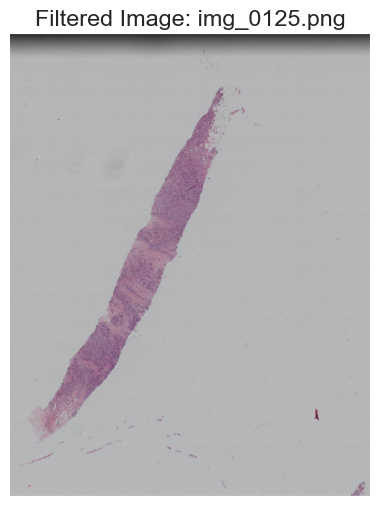

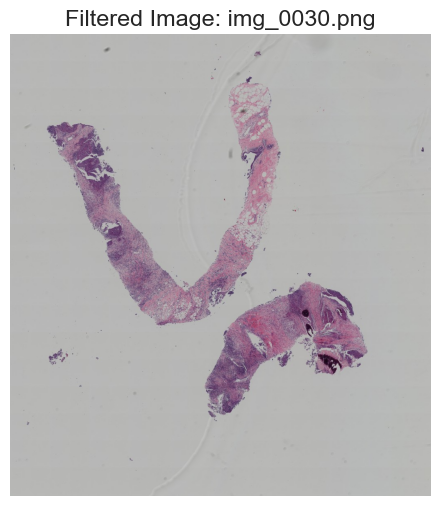

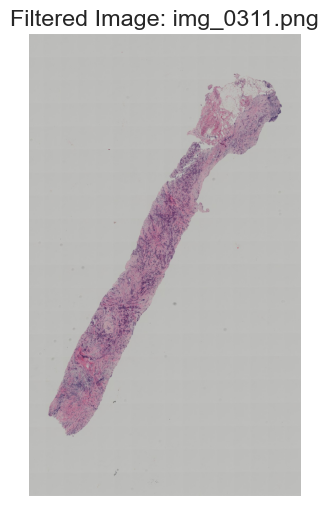

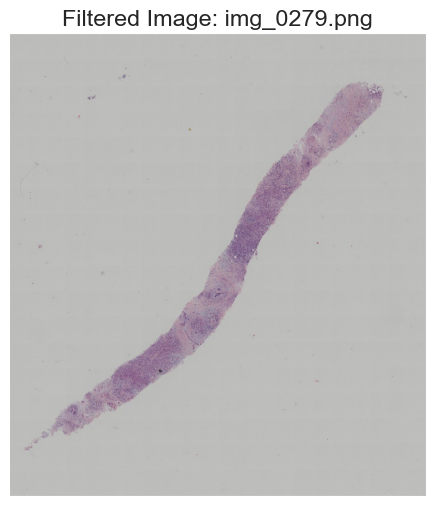

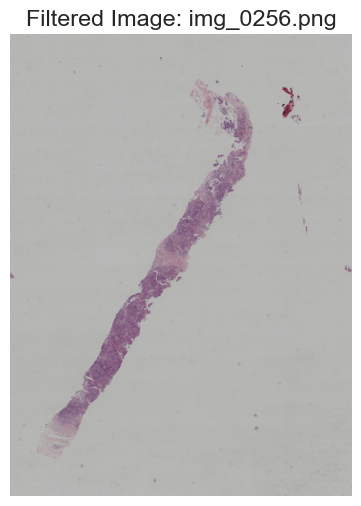

In [43]:
source_dir = Path(SOURCE_FOLDER)

# Create a new directory for filtered images
filtered_images_dir = datasets_path / "filtered_images"
os.makedirs(filtered_images_dir, exist_ok=True)

# Get all image files (only img_*.png, not masks)
image_files = sorted(glob.glob(os.path.join(source_dir, "img_*.png")))
print(f"Found {len(image_files)} images to process")

# Track statistics
shrek_images_excluded = []
images_with_goo_cleaned = []
clean_images_copied = []

for image_path in tqdm(image_files, desc="Processing images"):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        continue
    
    image_name = os.path.basename(image_path)
    
    # Step 1: Check if this is a Shrek image (yellow-olive tissue)
    is_shrek, yellow_ratio = detect_shrek_image(image, yellow_olive_threshold=0.05)  # 5% yellow-olive threshold
    
    if is_shrek:
        # Skip this image entirely - don't save filtered image OR mask
        shrek_images_excluded.append((image_name, f"{yellow_ratio*100:.1f}%"))
        
        # Also delete/skip the corresponding mask
        mask_name = image_name.replace("img_", "mask_")
        print(f"  Excluding Shrek image and mask: {image_name} / {mask_name}")
        continue
    
    # Step 2: Apply green goo filter for bright green contamination
    # Check for bright saturated green goo
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    green_mask = cv2.inRange(hsv, np.array([40, 80, 50]), np.array([90, 255, 255]))
    green_ratio = np.count_nonzero(green_mask) / (image.shape[0] * image.shape[1])
    
    if green_ratio > 0.001:  # If there's any bright green (>0.1%), clean it
        result_bgr, final_mask = filter_green_goo(image)
        images_with_goo_cleaned.append((image_name, f"{green_ratio*100:.1f}%"))
    else:
        # Clean image - just copy as-is
        result_bgr = image
        clean_images_copied.append(image_name)
    
    # Save the filtered/clean image
    filtered_image_path = os.path.join(filtered_images_dir, image_name)
    cv2.imwrite(filtered_image_path, result_bgr)

# Print summary
print(f"\n{'='*60}")
print(f"PROCESSING COMPLETE!")
print(f"{'='*60}")
print(f"Total images processed: {len(image_files)}")
print(f"Shrek images excluded: {len(shrek_images_excluded)}")
print(f"Images with green goo cleaned: {len(images_with_goo_cleaned)}")
print(f"Clean images copied: {len(clean_images_copied)}")
print(f"Total images saved: {len(images_with_goo_cleaned) + len(clean_images_copied)}")
print(f"Note: Corresponding Shrek masks were also excluded")

if shrek_images_excluded:
    print(f"\n{'='*60}")
    print("EXCLUDED SHREK IMAGES (Yellow-Olive Tissue):")
    for img_name, ratio in shrek_images_excluded[:20]:  # Show first 20
        mask_name = img_name.replace("img_", "mask_")
        print(f"  - {img_name} + {mask_name} (Yellow-Olive: {ratio})")
    if len(shrek_images_excluded) > 20:
        print(f"  ... and {len(shrek_images_excluded) - 20} more")

# Show examples
filtered_files = glob.glob(os.path.join(filtered_images_dir, "*.png"))
num_examples = min(5, len(filtered_files))

if num_examples > 0:
    print(f"\n{'='*60}")
    print("SAMPLE FILTERED IMAGES:")
    example_images = random.sample(filtered_files, num_examples)
    
    for img_path in example_images:
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6, 6))
        plt.imshow(img_rgb)
        plt.title(f"Filtered Image: {os.path.basename(img_path)}")
        plt.axis('off')
        plt.show()


## 2. **Dataset Patches**

In [44]:
# Load the filtered RGB images and their corresponding masks
filtered_images_folder = datasets_path / "filtered_images"
train_folder = datasets_path / "train_data"

# Get list of filtered image filenames (Shrek images were excluded during filtering)
filtered_image_paths = sorted(filtered_images_folder.glob("img_*.png"))
filtered_image_names = [img_path.name for img_path in filtered_image_paths]

print(f"Found {len(filtered_image_names)} filtered images (Shrek images already excluded)")

# Load the filtered RGB images, original images, and masks BY MATCHING FILENAMES
# This ensures correct alignment even though Shrek images were excluded
filtered_images = []
original_images = []
masked_images = []

for img_name in filtered_image_names:
    # Load filtered image
    filtered_img_path = filtered_images_folder / img_name
    filtered_img = cv2.imread(str(filtered_img_path))
    if filtered_img is None:
        print(f"Error loading filtered image: {img_name}")
        continue
    filtered_images.append(filtered_img)
    
    # Load corresponding original image (same filename in train_data/)
    orig_img_path = train_folder / img_name
    orig_img = cv2.imread(str(orig_img_path))
    if orig_img is None:
        print(f"Error loading original image: {img_name}")
        continue
    original_images.append(orig_img)
    
    # Load corresponding mask (replace "img_" with "mask_" in filename)
    mask_name = img_name.replace("img_", "mask_")
    mask_path = train_folder / mask_name
    mask_img = cv2.imread(str(mask_path))
    if mask_img is None:
        print(f"Error loading mask: {mask_name}")
        continue
    masked_images.append(mask_img)

print(f"Loaded {len(filtered_images)} filtered images")
print(f"Loaded {len(original_images)} original images")
print(f"Loaded {len(masked_images)} masks")

# Verify alignment
if len(filtered_images) == len(original_images) == len(masked_images):
    print(f"✓ All arrays are perfectly aligned ({len(filtered_images)} images)")
else:
    print(f"✗ WARNING: Arrays are NOT aligned!")
    print(f"  Filtered: {len(filtered_images)}, Original: {len(original_images)}, Masks: {len(masked_images)}")

def detect_green_goo_regions(original_image):
    """
    Detect green goo regions in the original image and return bounding boxes.
    
    Args:
        original_image: Original unfiltered image in BGR format (0-255 range)
    Returns:
        bounding_boxes: List of (x, y, w, h) bounding boxes for green goo regions
        green_mask: Binary mask showing green goo locations
    """
    hsv = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)
    
    # Detect bright saturated green contamination (same as filter_green_goo)
    lower_green_bright = np.array([35, 70, 40])
    upper_green_bright = np.array([95, 255, 255])
    green_mask_bright = cv2.inRange(hsv, lower_green_bright, upper_green_bright)
    
    # Detect subtle/pale green tones
    lower_green_pale = np.array([30, 30, 50])
    upper_green_pale = np.array([100, 120, 255])
    green_mask_pale = cv2.inRange(hsv, lower_green_pale, upper_green_pale)
    
    # Detect very bright pale green
    lower_green_very_pale = np.array([25, 20, 180])
    upper_green_very_pale = np.array([110, 80, 255])
    green_mask_very_pale = cv2.inRange(hsv, lower_green_very_pale, upper_green_very_pale)
    
    # Combine all green masks
    green_mask = cv2.bitwise_or(green_mask_bright, green_mask_pale)
    green_mask = cv2.bitwise_or(green_mask, green_mask_very_pale)
    
    # Morphological operations
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_OPEN, kernel_small, iterations=1)
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_CLOSE, kernel_medium, iterations=2)
    green_mask = cv2.dilate(green_mask, kernel_medium, iterations=2)
    
    # Find contours for bounding boxes
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    bounding_boxes = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:  # Filter very small detections
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append((x, y, w, h))
    
    return bounding_boxes, green_mask


def create_mask_with_green_exclusion(original_mask, green_bounding_boxes, min_tissue_area=5000):
    """
    Create a cleaned mask by:
    1. Excluding regions where green goo was detected
    2. Removing small tissue artifacts
    
    Args:
        original_mask: Original binary mask
        green_bounding_boxes: List of (x, y, w, h) for green goo regions
        min_tissue_area: Minimum area threshold for tissue components
    Returns:
        cleaned_mask: Mask with artifacts removed and green regions excluded
        components_kept: Number of tissue components kept
    """
    # Convert to grayscale if needed
    if len(original_mask.shape) == 3:
        gray_mask = cv2.cvtColor(original_mask, cv2.COLOR_BGR2GRAY)
    else:
        gray_mask = original_mask.copy()
    
    # Threshold to ensure binary mask
    _, binary_mask = cv2.threshold(gray_mask, 127, 255, cv2.THRESH_BINARY)
    
    # Remove regions where green goo was detected
    for (x, y, w, h) in green_bounding_boxes:
        # Expand bounding box slightly to ensure complete removal
        padding = 10
        x1 = max(0, x - padding)
        y1 = max(0, y - padding)
        x2 = min(binary_mask.shape[1], x + w + padding)
        y2 = min(binary_mask.shape[0], y + h + padding)
        
        # Set green goo region to black (remove from mask)
        binary_mask[y1:y2, x1:x2] = 0
    
    # Find all connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    
    # Create clean mask
    cleaned_mask = np.zeros_like(binary_mask)
    
    # Keep only large enough tissue components
    components_kept = 0
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_tissue_area:
            cleaned_mask[labels == i] = 255
            components_kept += 1
    
    # Convert back to BGR if original was BGR
    if len(original_mask.shape) == 3:
        cleaned_mask = cv2.cvtColor(cleaned_mask, cv2.COLOR_GRAY2BGR)
    
    return cleaned_mask, components_kept


# Clean all masks to remove small white artifacts AND exclude green goo regions
print("\nCleaning masks: excluding green goo regions and removing small artifacts...")
cleaned_masked_images = []
total_artifacts_removed = 0
total_green_regions_excluded = 0

for idx, (orig_img, orig_msk) in enumerate(zip(original_images, masked_images)):
    # Detect green goo in original image
    green_boxes, green_mask = detect_green_goo_regions(orig_img)
    total_green_regions_excluded += len(green_boxes)
    
    # Create cleaned mask excluding green regions
    cleaned_msk, components_kept = create_mask_with_green_exclusion(
        orig_msk, 
        green_boxes, 
        min_tissue_area=50
    )
    
    # Count removed pixels
    if len(orig_msk.shape) == 3:
        orig_white = np.count_nonzero(cv2.cvtColor(orig_msk, cv2.COLOR_BGR2GRAY))
        clean_white = np.count_nonzero(cv2.cvtColor(cleaned_msk, cv2.COLOR_BGR2GRAY))
    else:
        orig_white = np.count_nonzero(orig_msk)
        clean_white = np.count_nonzero(cleaned_msk)
    
    removed = orig_white - clean_white
    total_artifacts_removed += removed
    
    cleaned_masked_images.append(cleaned_msk)
    
    if len(green_boxes) > 0:
        print(f"  Image {idx} ({filtered_image_names[idx]}): Excluded {len(green_boxes)} green goo regions")

print(f"\nCleaned {len(cleaned_masked_images)} masks")
print(f"Total green goo regions excluded: {total_green_regions_excluded}")
print(f"Total artifact pixels removed: {total_artifacts_removed}")
print(f"Using min_tissue_area threshold: 50 pixels")

# Replace original masks with cleaned masks
masked_images = cleaned_masked_images

# Extract patches from filtered images based on mask tissue locations with coordinates
def extract_patches_with_coords(filtered_image, mask, patch_size=224, stride=224, min_tissue_ratio=0.1):
    """
    Extract patches from the filtered RGB image where the tissue ratio in the mask exceeds a minimum threshold.
    Returns patches with their coordinates for visualization.
    
    Args:
        filtered_image: Filtered RGB image in BGR format (0-255 range)
        mask: Corresponding binary mask (0 or 255)
        patch_size: Size of the square patches to extract
        stride: Stride for patch extraction (set equal to patch_size for no overlap)
        min_tissue_ratio: Minimum ratio of tissue pixels required to keep the patch
    Returns:
        patches: List of tuples (patch_image, tissue_ratio, x, y)
    """
    patches = []
    img_h, img_w = filtered_image.shape[:2]
    
    for y in range(0, img_h - patch_size + 1, stride):
        for x in range(0, img_w - patch_size + 1, stride):
            # Extract patch from FILTERED image
            patch_img = filtered_image[y:y+patch_size, x:x+patch_size]
            # Check tissue ratio using MASK
            patch_mask = mask[y:y+patch_size, x:x+patch_size]
            
            # Calculate tissue ratio from mask
            tissue_pixels = np.count_nonzero(patch_mask)
            total_pixels = patch_size * patch_size
            tissue_ratio = tissue_pixels / total_pixels
            
            # Keep patch if tissue ratio exceeds threshold
            if tissue_ratio >= min_tissue_ratio:
                patches.append((patch_img, tissue_ratio, x, y))
    
    return patches


Found 627 filtered images (Shrek images already excluded)
Loaded 627 filtered images
Loaded 627 original images
Loaded 627 masks
✓ All arrays are perfectly aligned (627 images)

Cleaning masks: excluding green goo regions and removing small artifacts...
  Image 1 (img_0001.png): Excluded 1 green goo regions
  Image 10 (img_0012.png): Excluded 1 green goo regions
  Image 16 (img_0018.png): Excluded 1 green goo regions
  Image 18 (img_0020.png): Excluded 1 green goo regions
Loaded 627 filtered images
Loaded 627 original images
Loaded 627 masks
✓ All arrays are perfectly aligned (627 images)

Cleaning masks: excluding green goo regions and removing small artifacts...
  Image 1 (img_0001.png): Excluded 1 green goo regions
  Image 10 (img_0012.png): Excluded 1 green goo regions
  Image 16 (img_0018.png): Excluded 1 green goo regions
  Image 18 (img_0020.png): Excluded 1 green goo regions
  Image 38 (img_0044.png): Excluded 1 green goo regions
  Image 44 (img_0052.png): Excluded 1 green goo 

In [45]:
# Filter out the images with too much background
def filter_bright_pixels(image, brightness_threshold=200, max_bright_ratio=0.5):
    """
    Filters out images with too many bright pixels (background).
    
    Args:
        image: Input image in BGR format (0-255 range)
        brightness_threshold: Pixel brightness threshold to consider as "bright"
        max_bright_ratio: Maximum allowed ratio of bright pixels to keep the image
    Returns:
        keep_image: Boolean indicating if the image should be kept
        bright_ratio: The ratio of bright pixels found
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bright_pixels = np.sum(gray >= brightness_threshold)
    total_pixels = gray.size
    bright_ratio = bright_pixels / total_pixels
    
    keep_image = bright_ratio <= max_bright_ratio
    return keep_image, bright_ratio

Total patches extracted: 2136
Patches filtered out (too bright): 0
Final patches saved: 2136
Retention rate: 100.0%


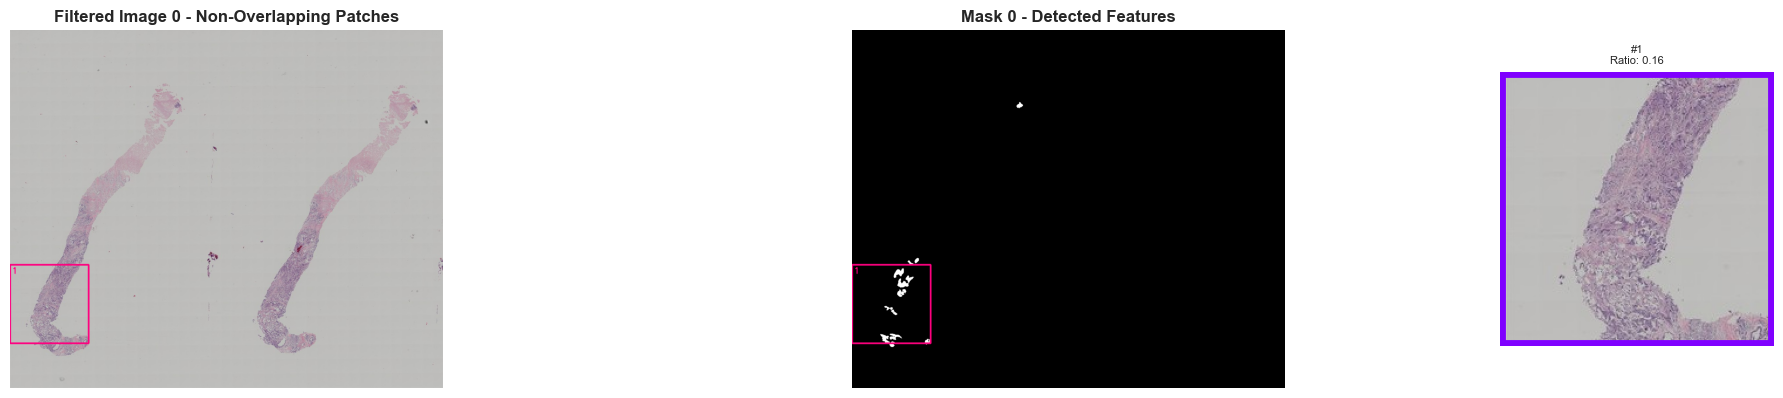

Image 0: Generated 1 non-overlapping patches (after brightness filtering)



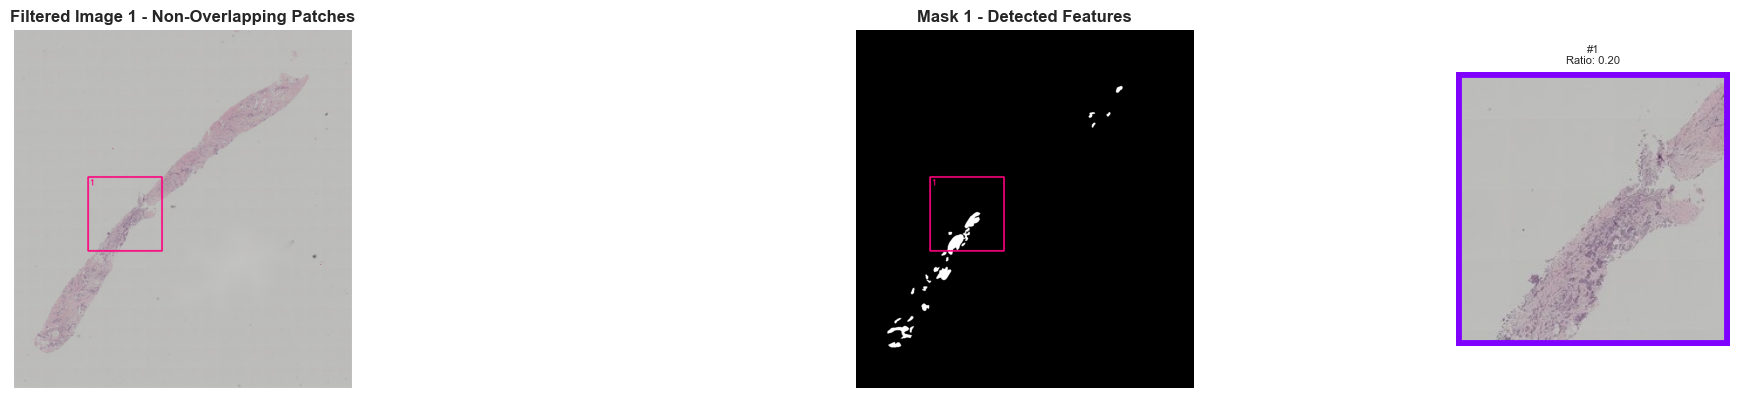

Image 1: Generated 1 non-overlapping patches (after brightness filtering)



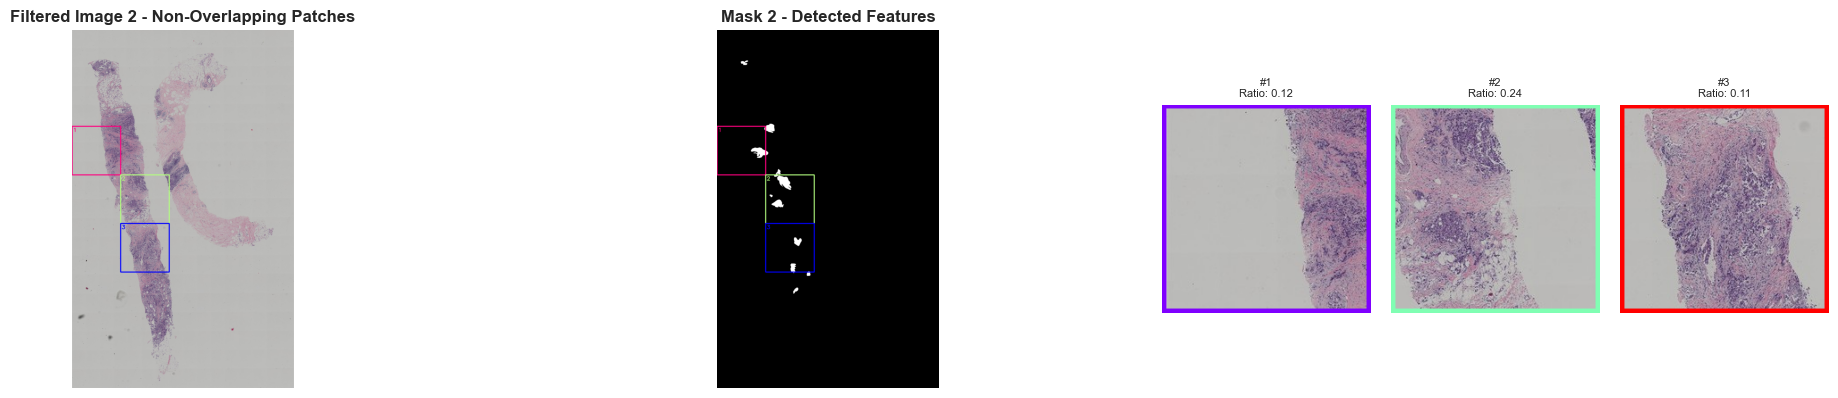

Image 2: Generated 3 non-overlapping patches (after brightness filtering)



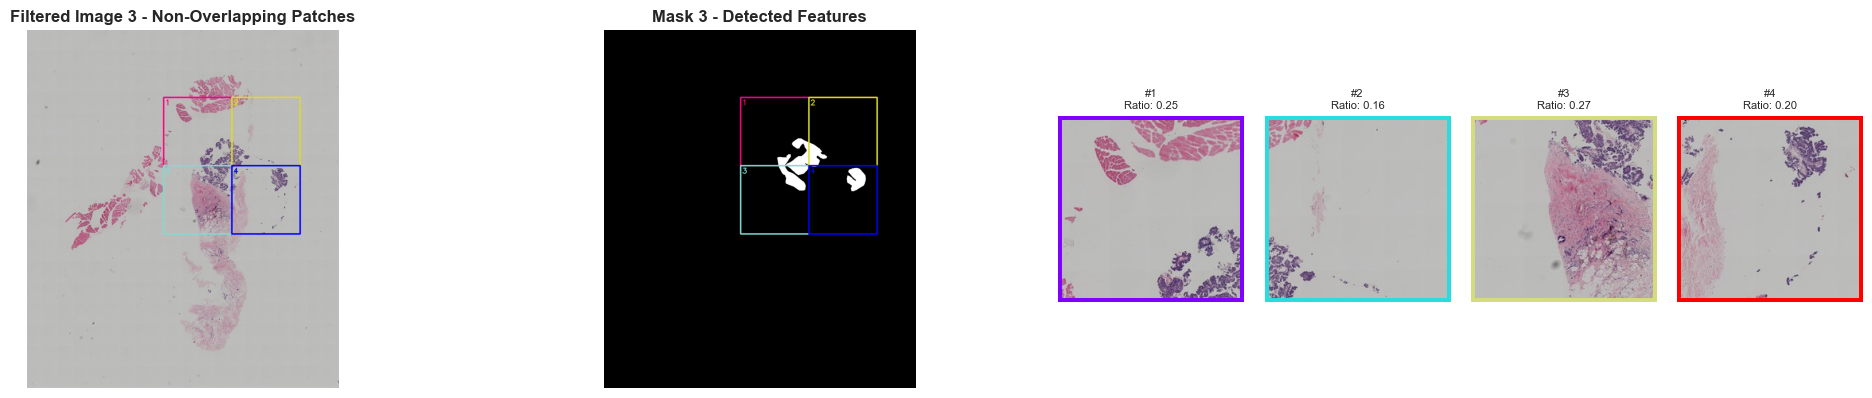

Image 3: Generated 4 non-overlapping patches (after brightness filtering)



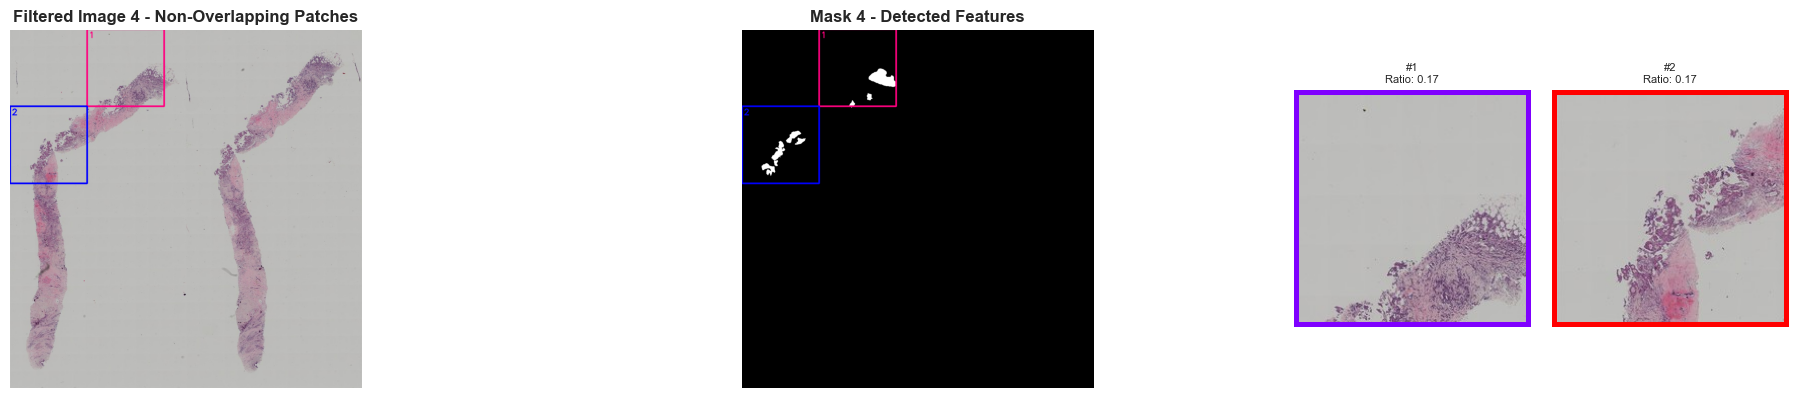

Image 4: Generated 2 non-overlapping patches (after brightness filtering)



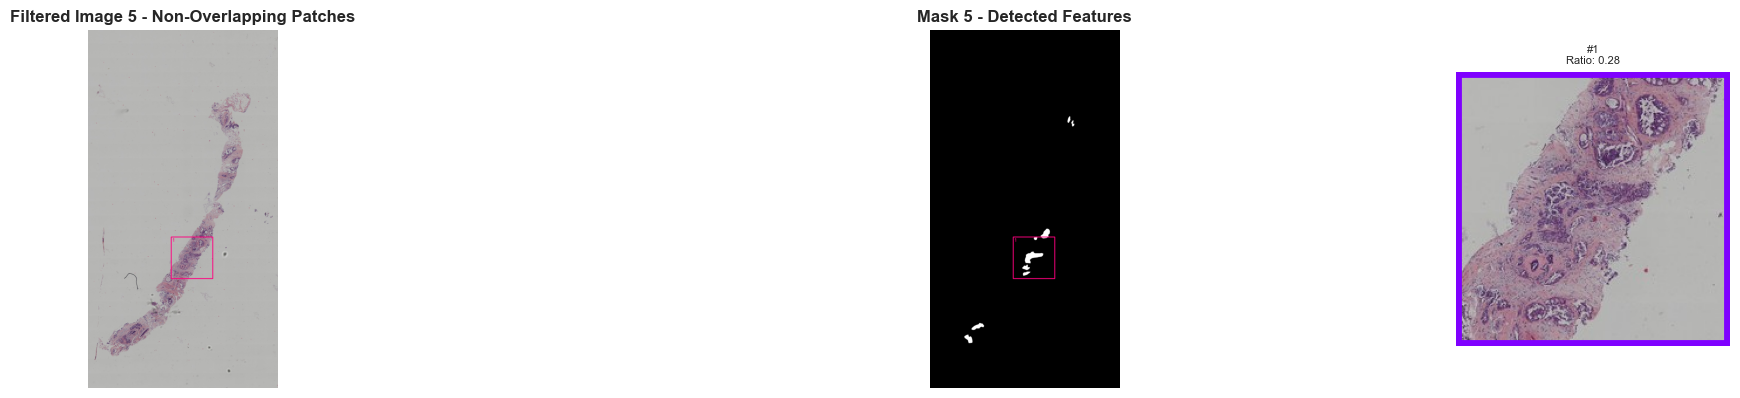

Image 5: Generated 1 non-overlapping patches (after brightness filtering)



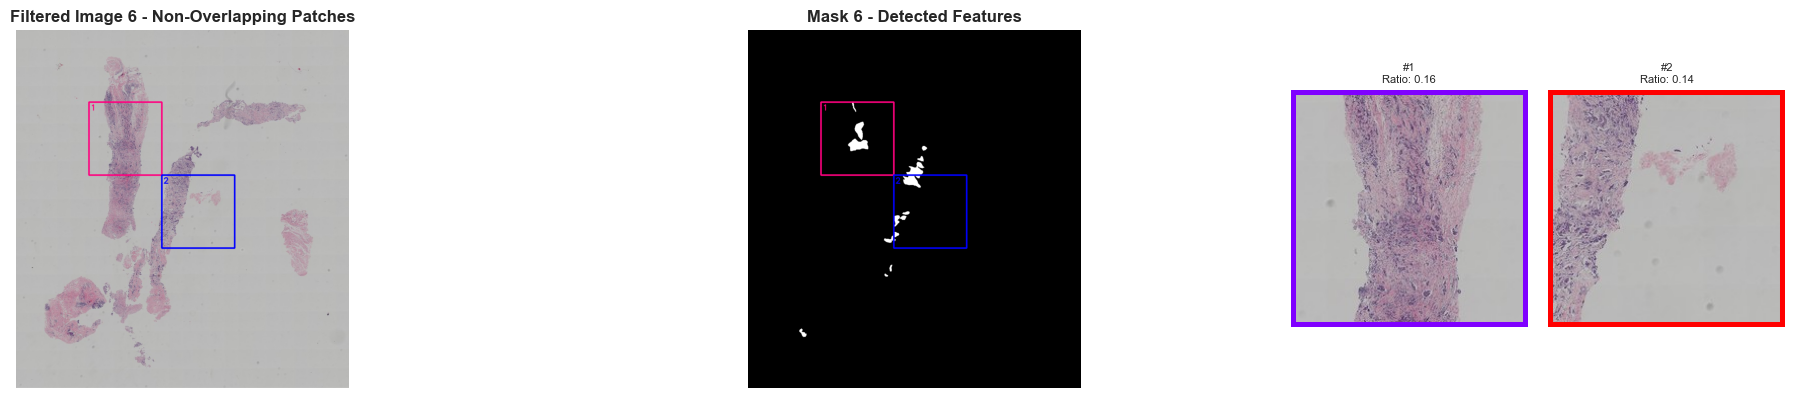

Image 6: Generated 2 non-overlapping patches (after brightness filtering)



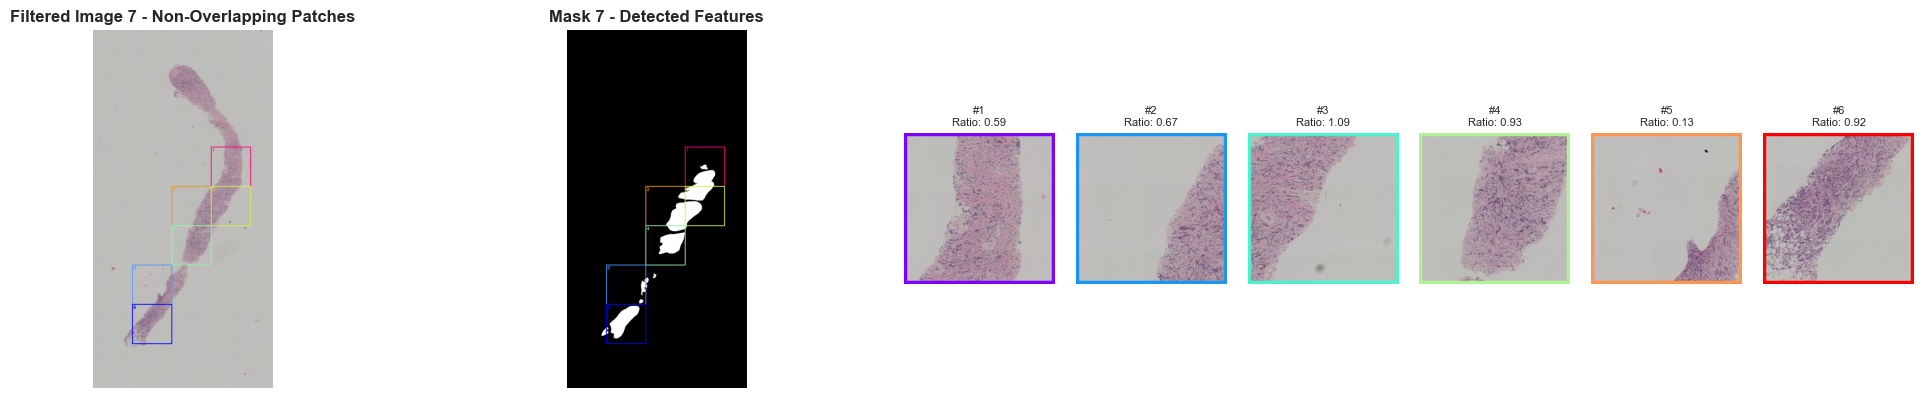

Image 7: Generated 6 non-overlapping patches (after brightness filtering)



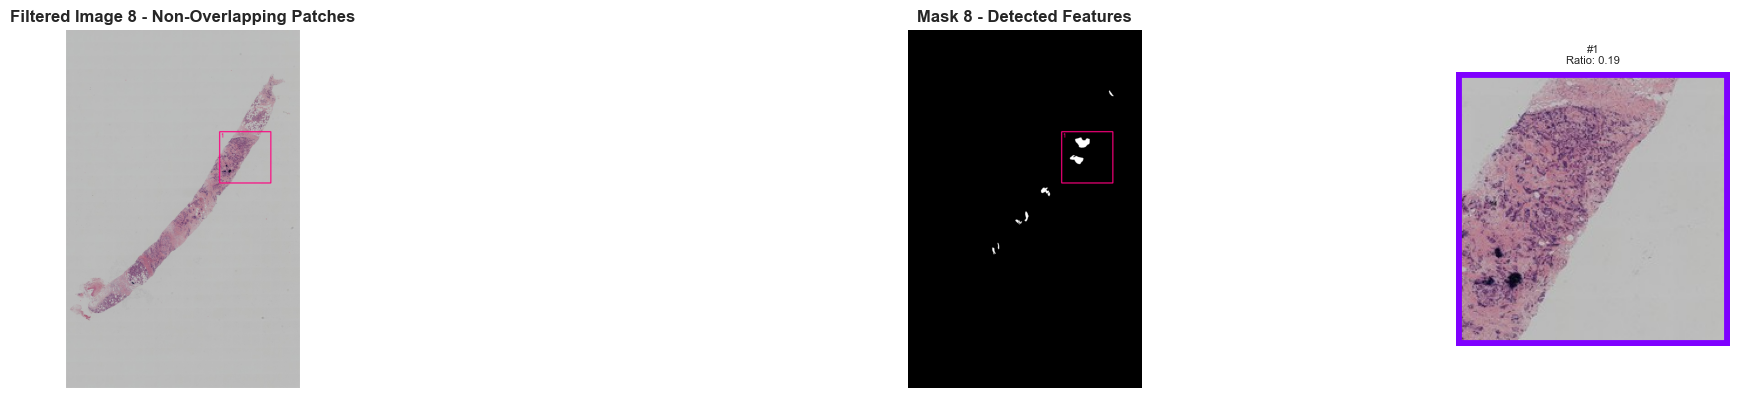

Image 8: Generated 1 non-overlapping patches (after brightness filtering)



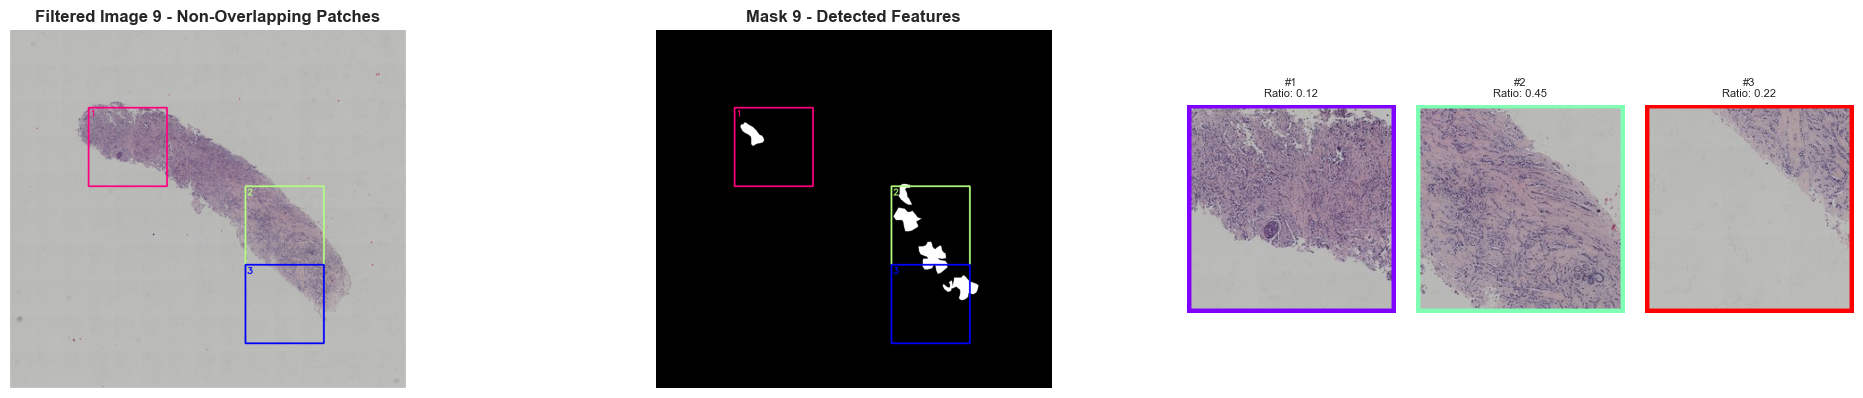

Image 9: Generated 3 non-overlapping patches (after brightness filtering)



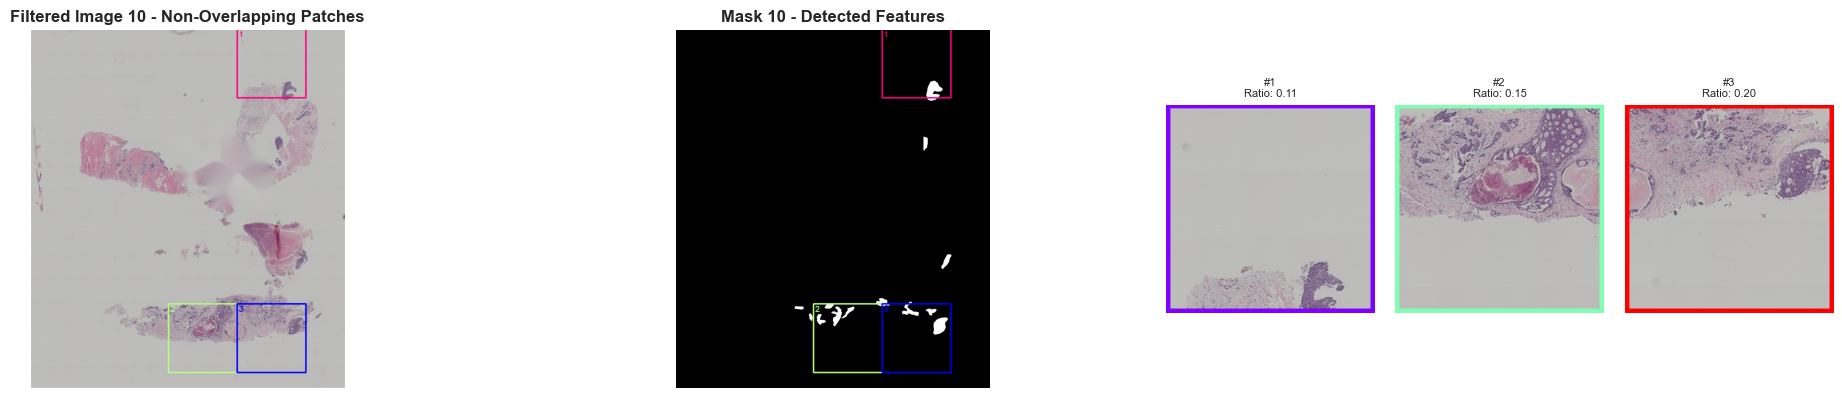

Image 10: Generated 3 non-overlapping patches (after brightness filtering)



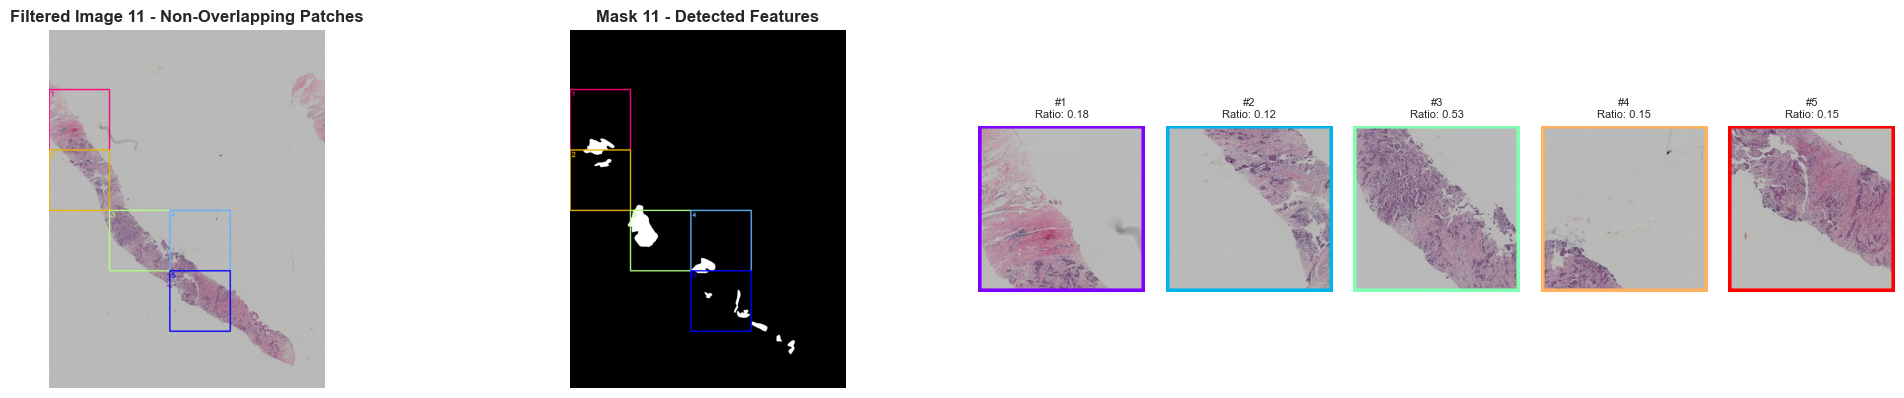

Image 11: Generated 5 non-overlapping patches (after brightness filtering)



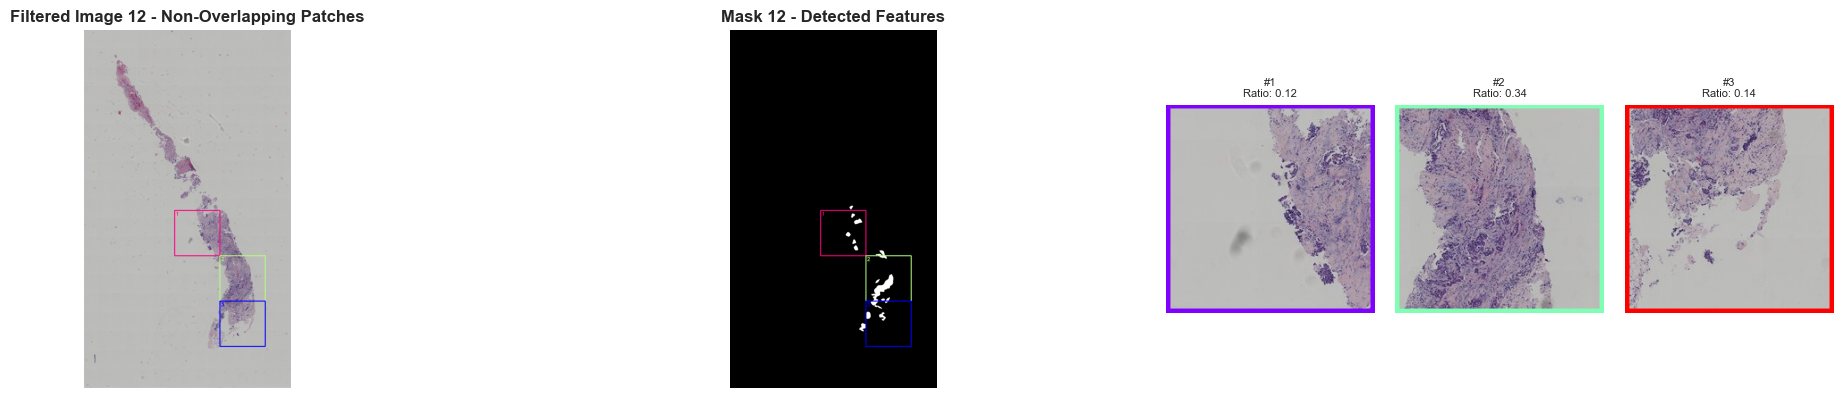

Image 12: Generated 3 non-overlapping patches (after brightness filtering)



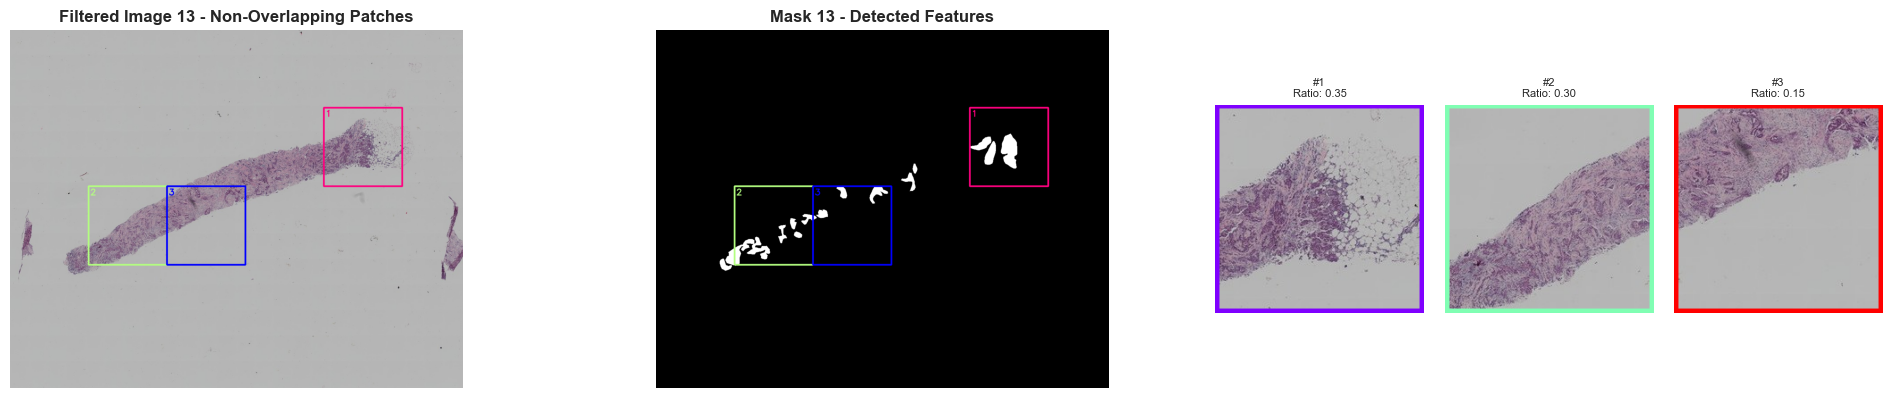

Image 13: Generated 3 non-overlapping patches (after brightness filtering)



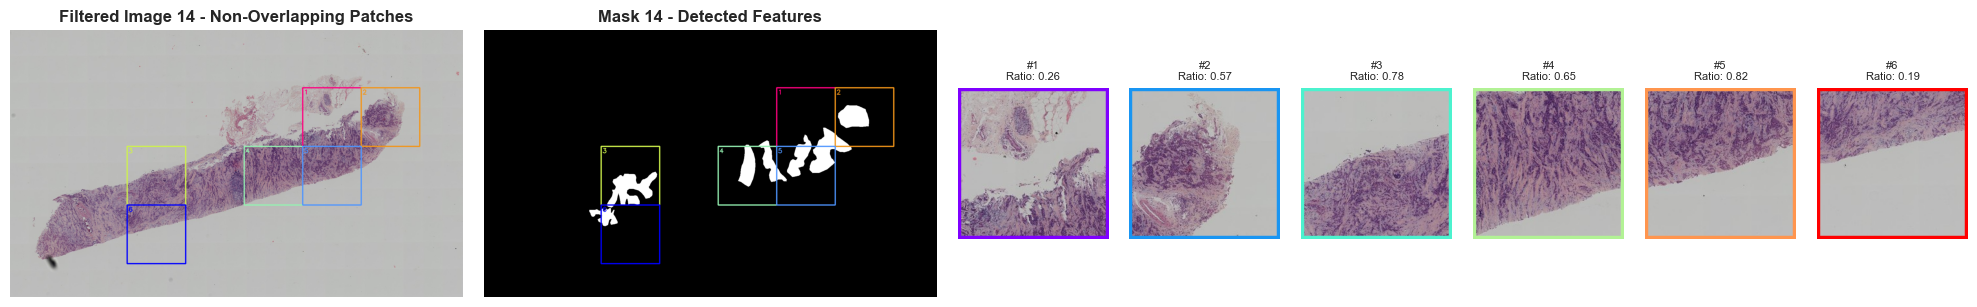

Image 14: Generated 6 non-overlapping patches (after brightness filtering)



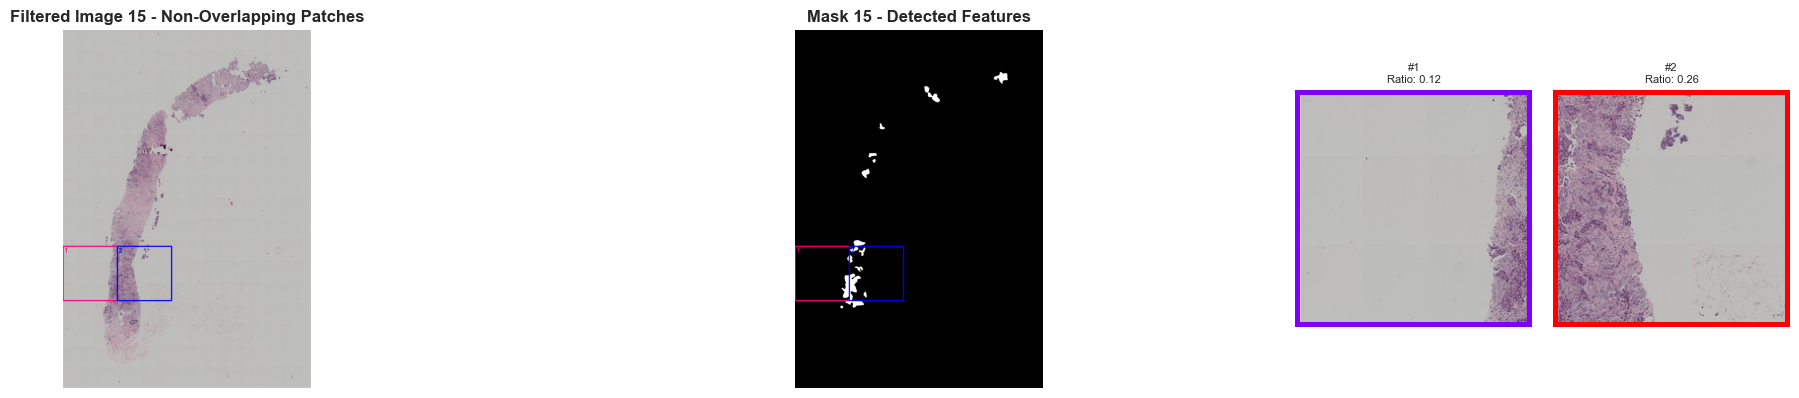

Image 15: Generated 2 non-overlapping patches (after brightness filtering)



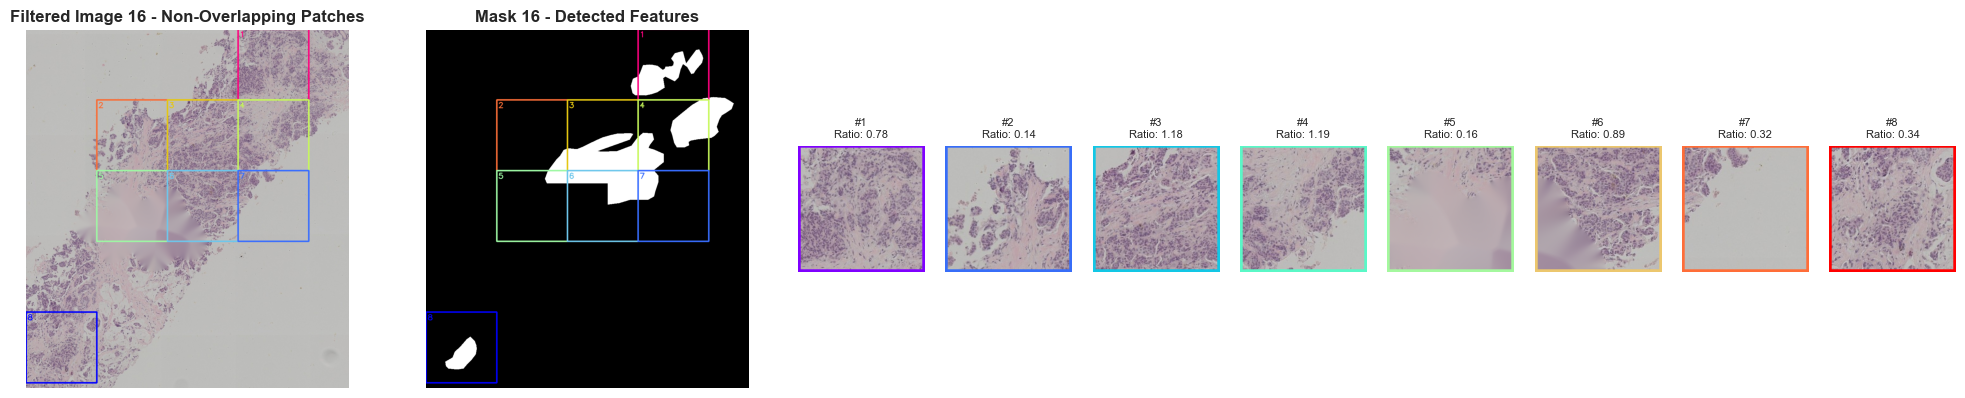

Image 16: Generated 8 non-overlapping patches (after brightness filtering)



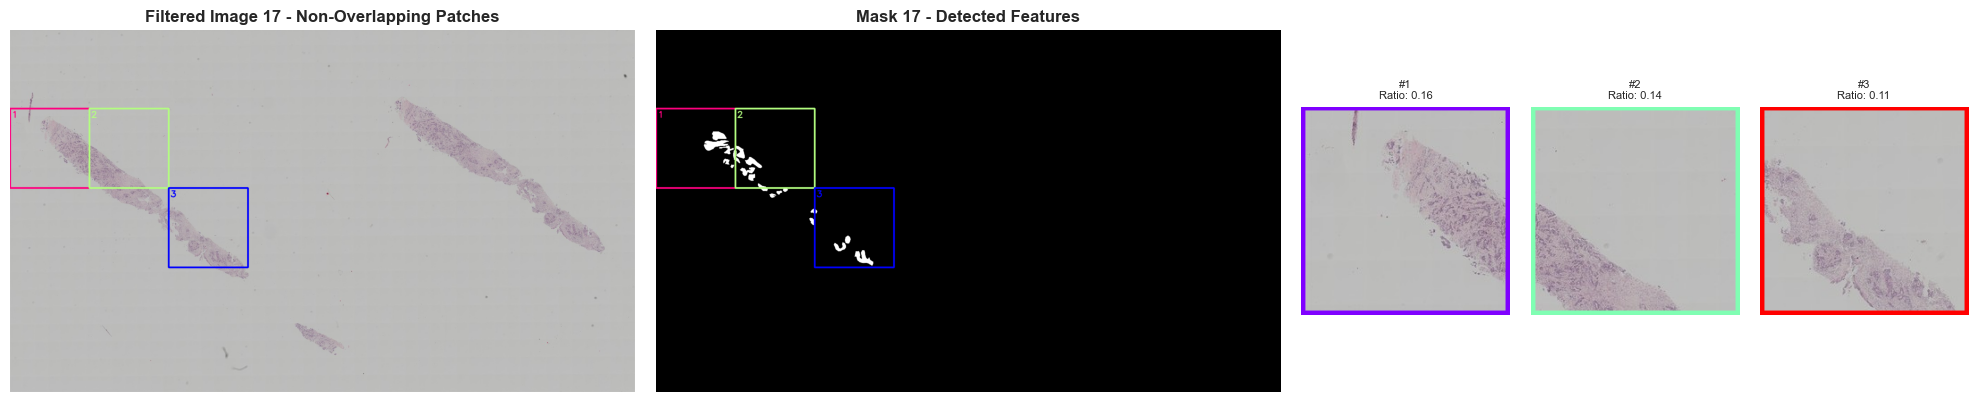

Image 17: Generated 3 non-overlapping patches (after brightness filtering)



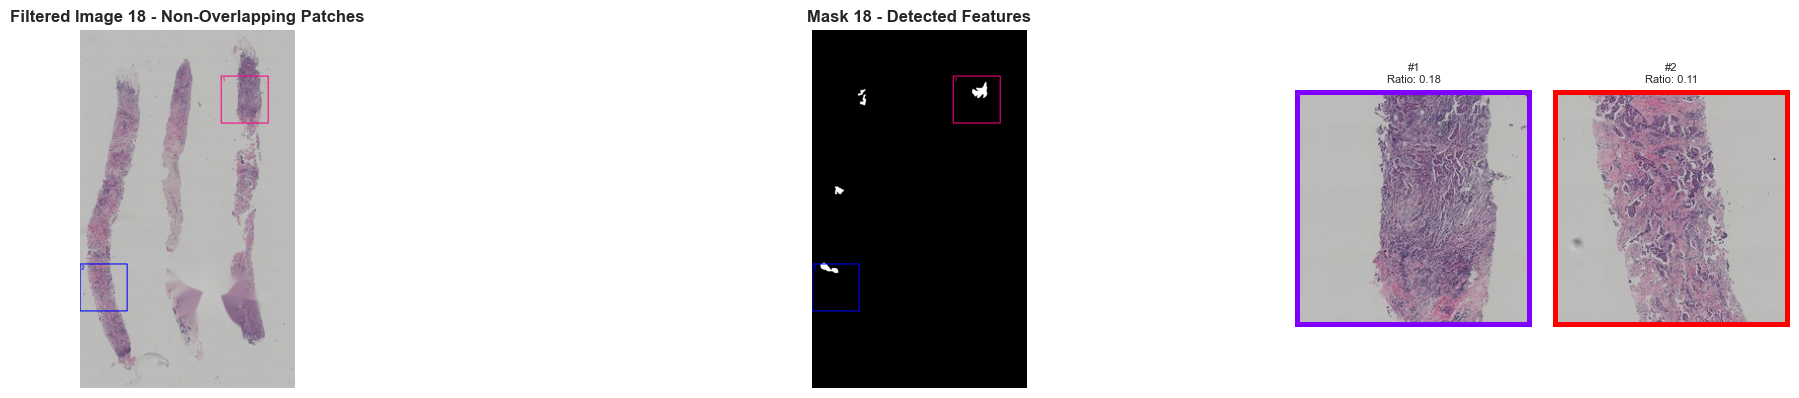

Image 18: Generated 2 non-overlapping patches (after brightness filtering)



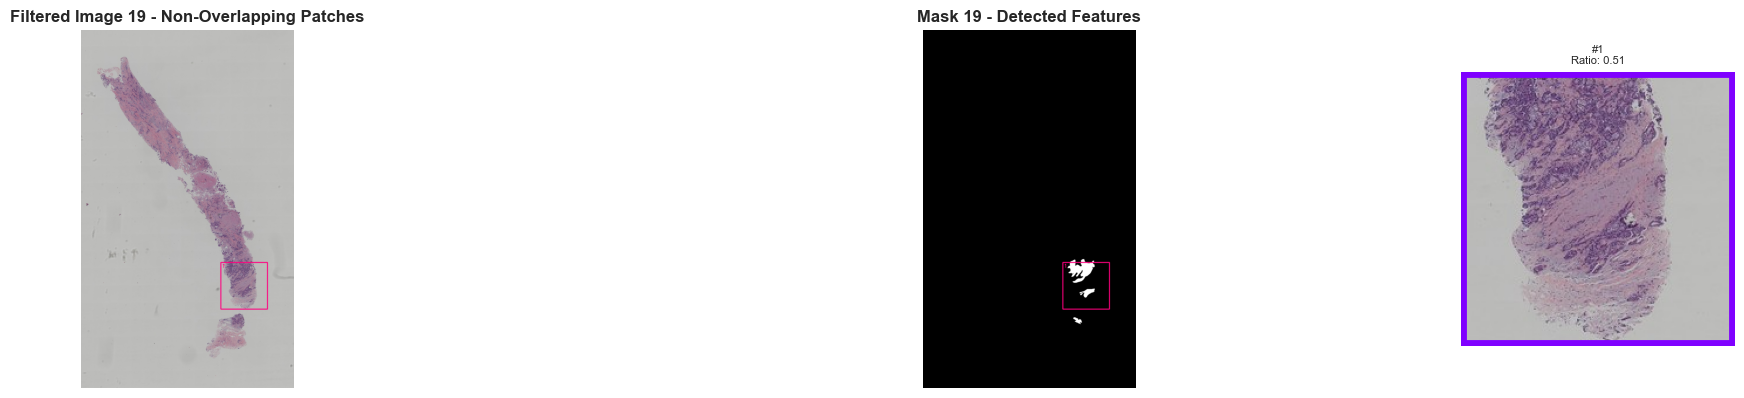

Image 19: Generated 1 non-overlapping patches (after brightness filtering)



In [47]:
# Get the patched data from filtered images
patched_data = []
filtered_patched_data_dir = datasets_path / "filtered_patched_data"

# Create directory if it doesn't exist
if not filtered_patched_data_dir.exists():
    os.makedirs(filtered_patched_data_dir)

# Statistics
total_patches_extracted = 0
patches_filtered_by_brightness = 0

# CONSISTENT BRIGHTNESS FILTERING PARAMETERS
BRIGHTNESS_THRESHOLD = 220
MAX_BRIGHT_RATIO = 0.7

# Process each filtered image and extract patches based on mask locations (NO OVERLAP)
for img_idx, (filtered_img, msk) in enumerate(zip(filtered_images, masked_images)):
    # Extract patches from filtered image at mask tissue locations with stride=224 (no overlap)
    patches = extract_patches_with_coords(filtered_img, msk, patch_size=224, stride=224, min_tissue_ratio=0.1)
    total_patches_extracted += len(patches)
    
    # Filter out bright patches
    filtered_patches = []
    for patch_img, tissue_ratio, x, y in patches:
        keep_patch, bright_ratio = filter_bright_pixels(patch_img, brightness_threshold=BRIGHTNESS_THRESHOLD, max_bright_ratio=MAX_BRIGHT_RATIO)
        if keep_patch:
            filtered_patches.append((patch_img, tissue_ratio, x, y))
        else:
            patches_filtered_by_brightness += 1
    
    # Save only the non-bright patches
    base_idx = len(patched_data)
    for i, (patch_img, tissue_ratio, x, y) in enumerate(filtered_patches):
        patch_filename = filtered_patched_data_dir / f"patch_{base_idx + i:05d}_img_{img_idx:04d}.png"
        cv2.imwrite(str(patch_filename), patch_img)
    
    patched_data.extend(filtered_patches)

print(f"Total patches extracted: {total_patches_extracted}")
print(f"Patches filtered out (too bright): {patches_filtered_by_brightness}")
print(f"Final patches saved: {len(patched_data)}")
print(f"Retention rate: {len(patched_data)/total_patches_extracted*100:.1f}%")

# Visualize patches with bounding boxes on filtered images and masks
num_examples = min(20, len(filtered_images))
if num_examples > 0:
    for img_idx in range(num_examples):
        filtered_img = filtered_images[img_idx]
        msk = masked_images[img_idx]
        
        # Extract patches for this specific image (NO OVERLAP)
        patches_all = extract_patches_with_coords(filtered_img, msk, patch_size=224, stride=224, min_tissue_ratio=0.1)
        
        # Filter out bright patches USING SAME PARAMETERS
        patches = []
        for patch_img, tissue_ratio, x, y in patches_all:
            keep_patch, _ = filter_bright_pixels(patch_img, brightness_threshold=BRIGHTNESS_THRESHOLD, max_bright_ratio=MAX_BRIGHT_RATIO)
            if keep_patch:
                patches.append((patch_img, tissue_ratio, x, y))
        
        if len(patches) == 0:
            print(f"Image {img_idx}: No valid patches after brightness filtering")
            continue
        
        # Create copies for drawing bounding boxes
        filtered_with_boxes = filtered_img.copy()
        mask_with_boxes = msk.copy()
        
        # Draw bounding boxes on both images (all patches, no overlap)
        num_patches_to_show = min(15, len(patches))
        colors = plt.cm.rainbow(np.linspace(0, 1, num_patches_to_show))
        
        for i in range(num_patches_to_show):
            patch_img, tissue_ratio, x, y = patches[i]
            color = tuple(int(c * 255) for c in colors[i][:3])
            
            # Draw rectangle on filtered image
            cv2.rectangle(filtered_with_boxes, (x, y), (x + 224, y + 224), color, 3)
            cv2.putText(filtered_with_boxes, f"{i+1}", (x+5, y+25), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
            
            # Draw rectangle on mask
            cv2.rectangle(mask_with_boxes, (x, y), (x + 224, y + 224), color, 3)
            cv2.putText(mask_with_boxes, f"{i+1}", (x+5, y+25), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        
        # Create visualization
        fig = plt.figure(figsize=(20, 8))
        gs = gridspec.GridSpec(2, 2 + num_patches_to_show, 
                               width_ratios=[3, 3] + [1]*num_patches_to_show,
                               height_ratios=[1, 1])
        
        # Row 1: Filtered image with bounding boxes
        ax0 = plt.subplot(gs[0, 0])
        filtered_rgb = cv2.cvtColor(filtered_with_boxes, cv2.COLOR_BGR2RGB)
        ax0.imshow(filtered_rgb)
        ax0.set_title(f"Filtered Image {img_idx} - Non-Overlapping Patches", fontsize=12, fontweight='bold')
        ax0.axis('off')
        
        # Row 1: Mask with bounding boxes
        ax1 = plt.subplot(gs[0, 1])
        mask_rgb = cv2.cvtColor(mask_with_boxes, cv2.COLOR_BGR2RGB)
        ax1.imshow(mask_rgb)
        ax1.set_title(f"Mask {img_idx} - Detected Features", fontsize=12, fontweight='bold')
        ax1.axis('off')
        
        # Row 1: Sample patches
        for i in range(num_patches_to_show):
            ax = plt.subplot(gs[0, 2 + i])
            patch_img, tissue_ratio, x, y = patches[i]
            patch_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB)
            
            # Add colored border matching the bounding box
            border_color = [int(c * 255) for c in colors[i][:3]]
            bordered_patch = cv2.copyMakeBorder(patch_rgb, 5, 5, 5, 5, 
                                               cv2.BORDER_CONSTANT, value=border_color)
            
            ax.imshow(bordered_patch)
            ax.set_title(f"#{i+1}\nRatio: {tissue_ratio:.2f}", fontsize=8)
            ax.axis('off')
        
        # Row 2: More patches if available
        for i in range(num_patches_to_show, min(num_patches_to_show * 2, len(patches))):
            col_idx = i - num_patches_to_show + 2
            if col_idx < 2 + num_patches_to_show:
                ax = plt.subplot(gs[1, col_idx])
                patch_img, tissue_ratio, x, y = patches[i]
                patch_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB)
                ax.imshow(patch_rgb)
                ax.set_title(f"Patch {i+1}\nRatio: {tissue_ratio:.2f}", fontsize=8)
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        print(f"Image {img_idx}: Generated {len(patches)} non-overlapping patches (after brightness filtering)\n")


Loading all patches and collecting pixel values...


Loading patches: 100%|██████████| 3713/3713 [00:37<00:00, 100.19it/s]




OVERALL STATISTICS FOR ALL PATCHES:
Total pixels analyzed: 186,303,488
Total patches: 3713

Red Channel:
  Mean:     0.683726
  Variance: 0.008107
  Std Dev:  0.090037

Green Channel:
  Mean:     0.650370
  Variance: 0.016746
  Std Dev:  0.129407

Blue Channel:
  Mean:     0.674869
  Variance: 0.007515
  Std Dev:  0.086690

Combined (for normalization):
  Mean (R, G, B): [0.683726, 0.650370, 0.674869]
  Std  (R, G, B): [0.090037, 0.129407, 0.086690]


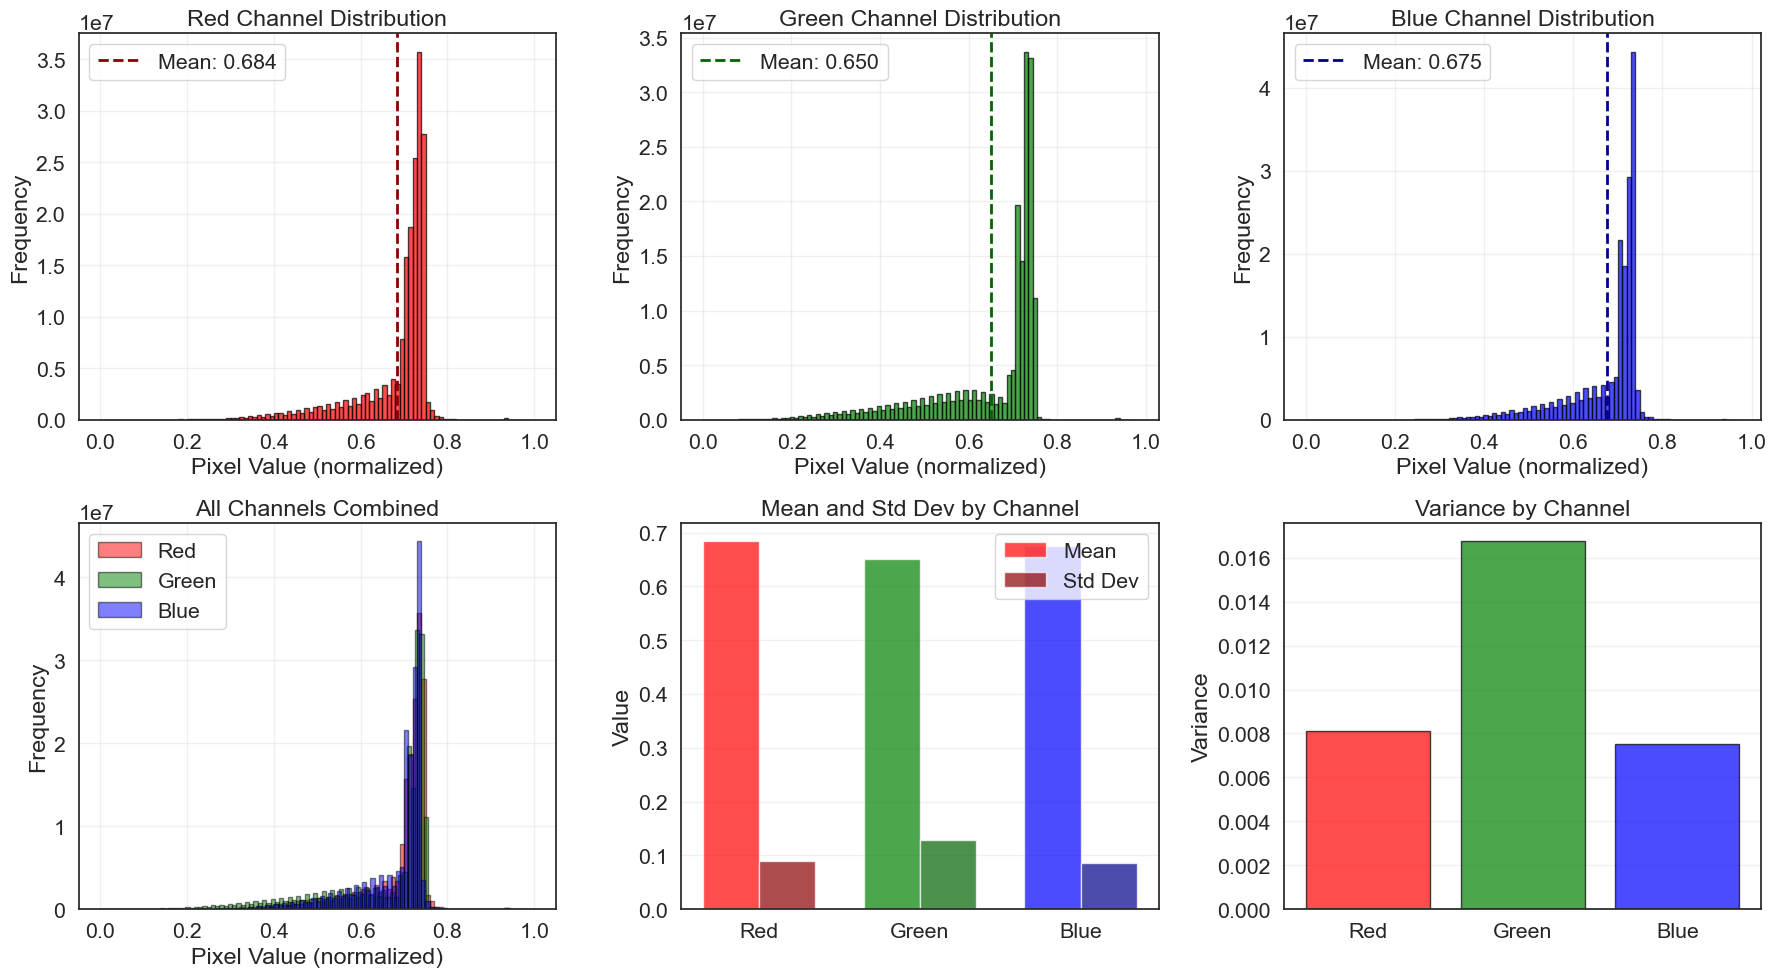


For PyTorch transforms.Normalize():
  mean=[0.683726, 0.650370, 0.674869]
  std=[0.090037, 0.129407, 0.086690]


In [52]:
# Collect all pixel values from all patches for each channel
all_red_pixels = []
all_green_pixels = []
all_blue_pixels = []

print("Loading all patches and collecting pixel values...")
for patch_path in tqdm(sorted(filtered_patched_data_dir.glob("patch_*.png")), desc="Loading patches"):
    patch_img = cv2.imread(str(patch_path))
    if patch_img is not None:
        patch_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB)
        
        # Flatten and collect all pixels for each channel
        all_red_pixels.extend(patch_rgb[:, :, 0].flatten())
        all_green_pixels.extend(patch_rgb[:, :, 1].flatten())
        all_blue_pixels.extend(patch_rgb[:, :, 2].flatten())

# Convert to numpy arrays
all_red_pixels = np.array(all_red_pixels) / 255.0  # Normalize to [0, 1]
all_green_pixels = np.array(all_green_pixels) / 255.0
all_blue_pixels = np.array(all_blue_pixels) / 255.0

# Compute overall mean and variance for each channel
mean_red = np.mean(all_red_pixels)
mean_green = np.mean(all_green_pixels)
mean_blue = np.mean(all_blue_pixels)

var_red = np.var(all_red_pixels)
var_green = np.var(all_green_pixels)
var_blue = np.var(all_blue_pixels)

std_red = np.std(all_red_pixels)
std_green = np.std(all_green_pixels)
std_blue = np.std(all_blue_pixels)

# Print statistics
print(f"\n{'='*60}")
print("OVERALL STATISTICS FOR ALL PATCHES:")
print(f"{'='*60}")
print(f"Total pixels analyzed: {len(all_red_pixels):,}")
print(f"Total patches: {len(list(filtered_patched_data_dir.glob('patch_*.png')))}")

print(f"\nRed Channel:")
print(f"  Mean:     {mean_red:.6f}")
print(f"  Variance: {var_red:.6f}")
print(f"  Std Dev:  {std_red:.6f}")

print(f"\nGreen Channel:")
print(f"  Mean:     {mean_green:.6f}")
print(f"  Variance: {var_green:.6f}")
print(f"  Std Dev:  {std_green:.6f}")

print(f"\nBlue Channel:")
print(f"  Mean:     {mean_blue:.6f}")
print(f"  Variance: {var_blue:.6f}")
print(f"  Std Dev:  {std_blue:.6f}")

print(f"\nCombined (for normalization):")
print(f"  Mean (R, G, B): [{mean_red:.6f}, {mean_green:.6f}, {mean_blue:.6f}]")
print(f"  Std  (R, G, B): [{std_red:.6f}, {std_green:.6f}, {std_blue:.6f}]")

# Plot distributions for each channel
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Histograms
axes[0, 0].hist(all_red_pixels, bins=100, alpha=0.7, color='red', edgecolor='black')
axes[0, 0].axvline(mean_red, color='darkred', linestyle='--', linewidth=2, label=f'Mean: {mean_red:.3f}')
axes[0, 0].set_title("Red Channel Distribution")
axes[0, 0].set_xlabel("Pixel Value (normalized)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(all_green_pixels, bins=100, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].axvline(mean_green, color='darkgreen', linestyle='--', linewidth=2, label=f'Mean: {mean_green:.3f}')
axes[0, 1].set_title("Green Channel Distribution")
axes[0, 1].set_xlabel("Pixel Value (normalized)")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].hist(all_blue_pixels, bins=100, alpha=0.7, color='blue', edgecolor='black')
axes[0, 2].axvline(mean_blue, color='darkblue', linestyle='--', linewidth=2, label=f'Mean: {mean_blue:.3f}')
axes[0, 2].set_title("Blue Channel Distribution")
axes[0, 2].set_xlabel("Pixel Value (normalized)")
axes[0, 2].set_ylabel("Frequency")
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Row 2: Combined histogram and statistics
axes[1, 0].hist(all_red_pixels, bins=100, alpha=0.5, color='red', label='Red', edgecolor='black')
axes[1, 0].hist(all_green_pixels, bins=100, alpha=0.5, color='green', label='Green', edgecolor='black')
axes[1, 0].hist(all_blue_pixels, bins=100, alpha=0.5, color='blue', label='Blue', edgecolor='black')
axes[1, 0].set_title("All Channels Combined")
axes[1, 0].set_xlabel("Pixel Value (normalized)")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Statistics comparison bar chart
channels = ['Red', 'Green', 'Blue']
means = [mean_red, mean_green, mean_blue]
stds = [std_red, std_green, std_blue]

x = np.arange(len(channels))
width = 0.35

axes[1, 1].bar(x - width/2, means, width, label='Mean', color=['red', 'green', 'blue'], alpha=0.7)
axes[1, 1].bar(x + width/2, stds, width, label='Std Dev', color=['darkred', 'darkgreen', 'darkblue'], alpha=0.7)
axes[1, 1].set_title("Mean and Std Dev by Channel")
axes[1, 1].set_ylabel("Value")
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(channels)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Variance comparison
variances = [var_red, var_green, var_blue]
axes[1, 2].bar(channels, variances, color=['red', 'green', 'blue'], alpha=0.7, edgecolor='black')
axes[1, 2].set_title("Variance by Channel")
axes[1, 2].set_ylabel("Variance")
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("For PyTorch transforms.Normalize():")
print(f"  mean=[{mean_red:.6f}, {mean_green:.6f}, {mean_blue:.6f}]")
print(f"  std=[{std_red:.6f}, {std_green:.6f}, {std_blue:.6f}]")
print(f"{'='*60}")

In [54]:
# Eliminate all the patches that have a mean higher then 0.7
def filter_bright_patches(patched_data, brightness_threshold=0.7):
    """
    Filters out patches with mean brightness above a certain threshold.
    
    Args:
        patched_data: List of tuples (patch_image, tissue_ratio, x, y)
        brightness_threshold: Maximum allowed mean brightness to keep the patch
    Returns:
        filtered_patched_data: List of tuples (patch_image, tissue_ratio, x, y) after filtering
    """
    filtered_patched_data = []
    
    for patch_img, tissue_ratio, x, y in patched_data:
        # Convert patch to RGB and normalize
        patch_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB) / 255.0
        mean_brightness = np.mean(patch_rgb)
        
        if mean_brightness <= brightness_threshold:
            filtered_patched_data.append((patch_img, tissue_ratio, x, y))
    
    return filtered_patched_data

In [55]:
# Get the patched data
filtered_patched_data = filter_bright_patches(patched_data, brightness_threshold=0.7)

# Save the new filtered patches
final_filtered_patched_data_dir = datasets_path / "final_filtered_patched_data"

if not final_filtered_patched_data_dir.exists():
    os.makedirs(final_filtered_patched_data_dir)

for i, (patch_img, tissue_ratio, x, y) in enumerate(filtered_patched_data):
    patch_filename = final_filtered_patched_data_dir / f"patch_{i:05d}.png"
    cv2.imwrite(str(patch_filename), patch_img)